<a href="https://colab.research.google.com/github/hoyeonj981/MyColab/blob/main/MMC_MC_Sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get update -qq
!pip install --quiet pandas numpy matplotlib

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

### [수집 데이터 Sheet ](https://docs.google.com/spreadsheets/d/1jjpcpmsi0MSbGH3qUmbc_LHutG-nZ6EXMVaUGpscMhE/edit?usp=sharing)

In [ ]:
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQ1eVWTm9TWsfTvFHiiGpelyebYDElKjOifrrrGpLa7hK6ltOOD8DAro1OS7PPS5xexT9_uSW8uJADp/pub?output=csv"
df = pd.read_csv(url)

## 1. 수집한 데이터 히스토그램

- 평균 132초
- 중간값 116초

###### 참고

- 수집한 데이터는 수기로 입력하기 때문에 실제 데이터와 차이가 있을 수 있음
- 예) 터치 불량, 개인 실수 등

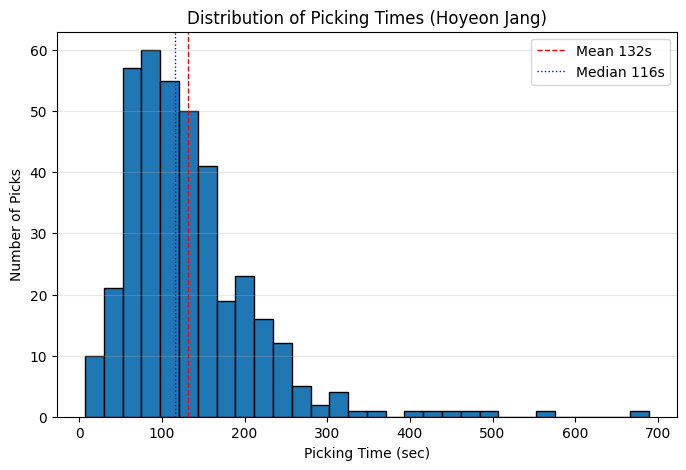

In [ ]:
# 피킹 소요 시간의 분포도

plt.figure(figsize=(8, 5))
plt.hist(df['DurationSec'], bins=30, edgecolor='black')
plt.xlabel('Picking Time (sec)')
plt.ylabel('Number of Picks')
plt.title('Distribution of Picking Times (Hoyeon Jang)')

mean_val   = df['DurationSec'].mean()
median_val = df['DurationSec'].median()
plt.axvline(mean_val,   color='red',  linestyle='--', linewidth=1,
            label=f'Mean {mean_val:.0f}s')
plt.axvline(median_val, color='blue', linestyle=':',  linewidth=1,
            label=f'Median {median_val:.0f}s')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.show()


## 2. 전체 주문에 대한 라벨링 분포도

- 80%가 정상 처리
- 20%가 지연 사유 (고중량, 재고 없음, 전산 불일치, 먼거리 이동)

### 2.1 지연 시간 중 상위 5%에 해당하는 지연 사유

- 260초 이상 지연이 발생하는 5% 그룹
- 그 중에서 약 44%가 '재고 없음'

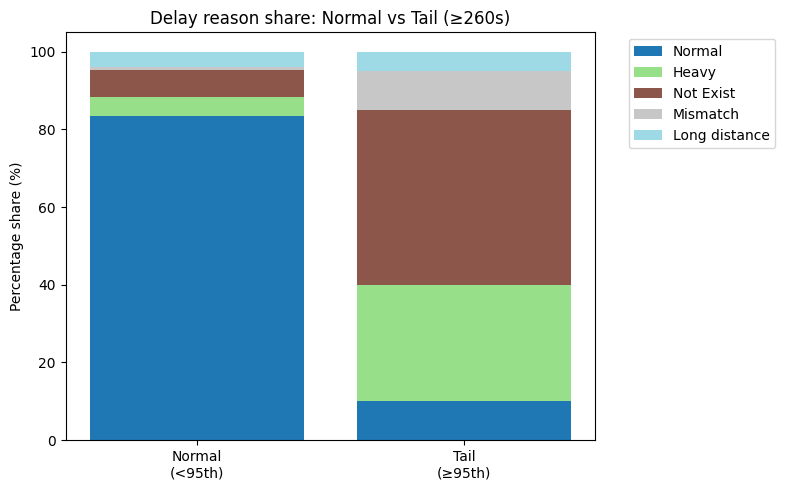

In [ ]:
DUR_COL = 'DurationSec'
REASON_COL = 'Result'

reason_map = {
    0: 'Normal',                # 정상 처리
    1: 'Heavy',                 # 고중량
    2: 'Not Exist',             # 재고 없음
    3: 'Mismatch',              # 전산 불일치
    4: 'Long distance'          # 먼거리 이동
}

# 장시간 임계값
tail_thr = np.percentile(df[DUR_COL], 95)   # 95

def share_by_reason(sub):
    c = sub[REASON_COL].value_counts(normalize=True) * 100
    return c

share_normal = share_by_reason(df[df[DUR_COL] <  tail_thr])
share_tail   = share_by_reason(df[df[DUR_COL] >= tail_thr])


all_reasons = share_normal.index.union(share_tail.index)
share_normal = share_normal.reindex(all_reasons, fill_value=0)
share_tail   = share_tail.reindex(all_reasons, fill_value=0)

fig, ax = plt.subplots(figsize=(8,5))
bottom = np.zeros(2)
colors = plt.cm.tab20(np.linspace(0, 1, len(all_reasons)))

for reason, color in zip(all_reasons, colors):
    vals  = [share_normal[reason], share_tail[reason]]
    label = reason_map.get(reason, str(reason))
    ax.bar(['Normal\n(<95th)', 'Tail\n(≥95th)'],
           vals, bottom=bottom, label=label, color=color)
    bottom += vals

ax.set_ylabel('Percentage share (%)')
ax.set_title(f'Delay reason share: Normal vs Tail (≥{tail_thr:.0f}s)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 현재 작업중 (파라미터 및 함수 수정)

## 3. 시뮬레이션 모델

- M/M/c + Monte Carlo

In [ ]:
def simulate_mmc(n_orders,
                 lam,
                 service_sampler,
                 c,
                 improve=1.0, sla_sec=600, seed=0):
    """
    Poisson 도착(λ) + 피커 c명 + 경험적 서비스시간을 쓰는 큐 시뮬레이터.
    improve = 0.6 → 서비스시간 40 % 단축.
    """
    rng = np.random.default_rng(seed)
    gaps = rng.exponential(scale=60/lam, size=n_orders)
    arrivals = np.cumsum(gaps)

    # 피커별 ‘다음 가능 시각’
    free = np.zeros(c)
    waits, totals = [], []

    for t in arrivals:
        idx = free.argmin()               # 가장 빨리 비는 피커
        start = max(t, free[idx])         # 대기 발생 여부
        waits.append(start - t)

        s = service_sampler(rng) * improve
        finish = start + s
        totals.append(finish - t)
        free[idx] = finish

    df = pd.DataFrame({"wait": waits, "total": totals})
    df["sla"] = df["total"] > sla_sec
    return df

In [ ]:
def kpi(df):
    return {
        "Mean(s)"   : df["total"].mean(),
        "P95(s)"    : np.percentile(df["total"], 95),
        "SLA > 10m %" : df["sla"].mean() * 100,
        "AvgWait(s)": df["wait"].mean()
    }

In [ ]:
# smaple orders
orders = 10000

# orders per minute
lam_peak = 120 / 60

# peakers
# 피커는 평균 2분 안에 피킹 완료
c_peak = 8

df = df.dropna(subset=["startTime", "DurationSec"]).copy()
df["start_dt"] = pd.to_datetime(df["startTime"])
df.sort_values("start_dt", inplace=True)
inter   = df["start_dt"].diff().dt.total_seconds().dropna()
service_times = df['DurationSec'].astype(float).dropna().values

# 수집한 데이터 기반 샘플러
def service_sampler_real(rng):
    return rng.choice(service_times)

def service_sampler_rnd(rng):
    if rng.random() < 0.45:
        return rng.exponential(scale=360)   # 무거운 주문: 평균 6분
    else:
        return rng.exponential(scale=120)   # 보통 주문: 평균 2분

print(f"Estimated λ = {lam_peak:.2f} orders/min")
print(f"sample size = {len(service_times)}")

Estimated λ = 2.00 orders/min
sample size = 384


In [ ]:
# 기존 방식
base_df  = simulate_mmc(
    n_orders = orders,
    lam = lam_peak,                  # orders per min
    service_sampler = service_sampler_real,
    c = c_peak,                      # pickers
    improve = 1.0,                   # 개선 없음
    sla_sec = 600,
    seed = 1
)

# 개선안 적용 (서비스시간 40% 단축)
after_df = simulate_mmc(
    n_orders = orders,
    lam = lam_peak,
    service_sampler = service_sampler_rnd,
    c = c_peak,
    improve = 0.6,                   # 서비스시간 ×0.6
    sla_sec = 600,
    seed = 1
)

base_kpi  = kpi(base_df)
base_kpi.update({'lam': lam_peak, 'c': c_peak})
after_kpi = kpi(after_df)
after_kpi.update({'lam': lam_peak, 'c': c_peak})

display(pd.DataFrame({'Baseline': base_kpi, 'After': after_kpi}).T.round(2))

,Mean(s),P95(s),SLA>10m %,AvgWait(s),lam,c
Baseline,133.74,267.00,0.27,2.61,2.0,8.0
After,143.41,492.04,2.95,6.30,2.0,8.0
